# Importing the Packages

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as  np
from sklearn.metrics import r2_score, mean_squared_error

# Data Importing

Import the data

In [235]:
restaurants = pd.read_csv('https://raw.githubusercontent.com/mohamad-selman/Meal-Prep-Time/main/restaurants.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/mohamad-selman/Meal-Prep-Time/main/orders.csv')

Join (left outer join) orders and restaurants tables on 'restaurant_id' (the primary key)

In [236]:
df = orders.merge(restaurants, how='left', on='restaurant_id')

# Data Preprocessing 

Check if there is any missing value

In [237]:
df.isnull().sum(axis=0)

order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
restaurant_id            0
number_of_items          0
prep_time_seconds        0
country                  0
city                     0
type_of_food             0
dtype: int64

Convert 'order_acknowledged_at' and 'order_ready_at' to datetime format

In [238]:
for c in ['order_acknowledged_at', 'order_ready_at']:
  df[c] = pd.to_datetime(df[c])

Remove timezone

In [239]:
for c in ['order_acknowledged_at', 'order_ready_at']:
  df[c] = df[c].apply(lambda x: x.replace(tzinfo=None))

## Removing Outliers

In [240]:
df.describe()

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
count,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857
std,19.263851,960.295504,2.392063,4404.573191
min,0.500000,3.000000,1.000000,0.000000
25%,16.700000,408.000000,3.000000,518.000000
50%,21.400000,1160.000000,3.000000,820.000000
75%,30.250000,2117.000000,5.000000,1227.000000
max,711.000000,3622.000000,38.000000,255499.000000


Max value is much larger than 75% percentile

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b0b0faa90>,
      dtype=object)

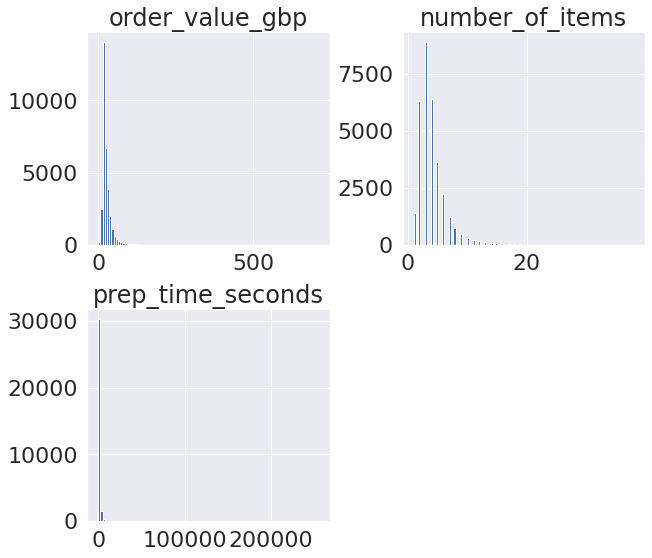

In [241]:
df.hist(column=['order_value_gbp', 'number_of_items', 'prep_time_seconds'], bins=100, figsize=(10, 9))

Use Interquartile Range (IQR) to find and drop the outliers

In [242]:
def drop_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  return df[~( (df[column] < lower_limit) | (df[column] > upper_limit) )]

Drop the outliers

In [243]:
df = drop_outliers(df, 'prep_time_seconds')
df = drop_outliers(df, 'order_value_gbp')

In [244]:
df = df.reset_index().drop(columns=['index'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b0ab09490>,
      dtype=object)

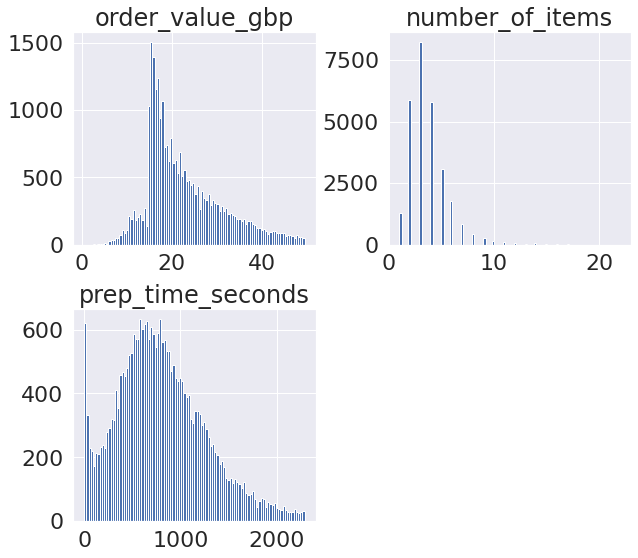

In [245]:
df.hist(column=['order_value_gbp', 'number_of_items', 'prep_time_seconds'], bins=100, figsize=(10, 9))

number_of_items was not trimmed to keep the model generalized

# Data Visualisation

Extract month, hour, weekday, and monthday from order_acknowledged_at


In [246]:
df['order_ack_month'] = df['order_acknowledged_at'].dt.month
df['order_ack_hour'] = df['order_acknowledged_at'].dt.hour
df['order_ack_weekday'] = df['order_acknowledged_at'].dt.day_name()
df['order_ack_monthday'] = df['order_acknowledged_at'].dt.day

## Number of Orders by Weekday

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

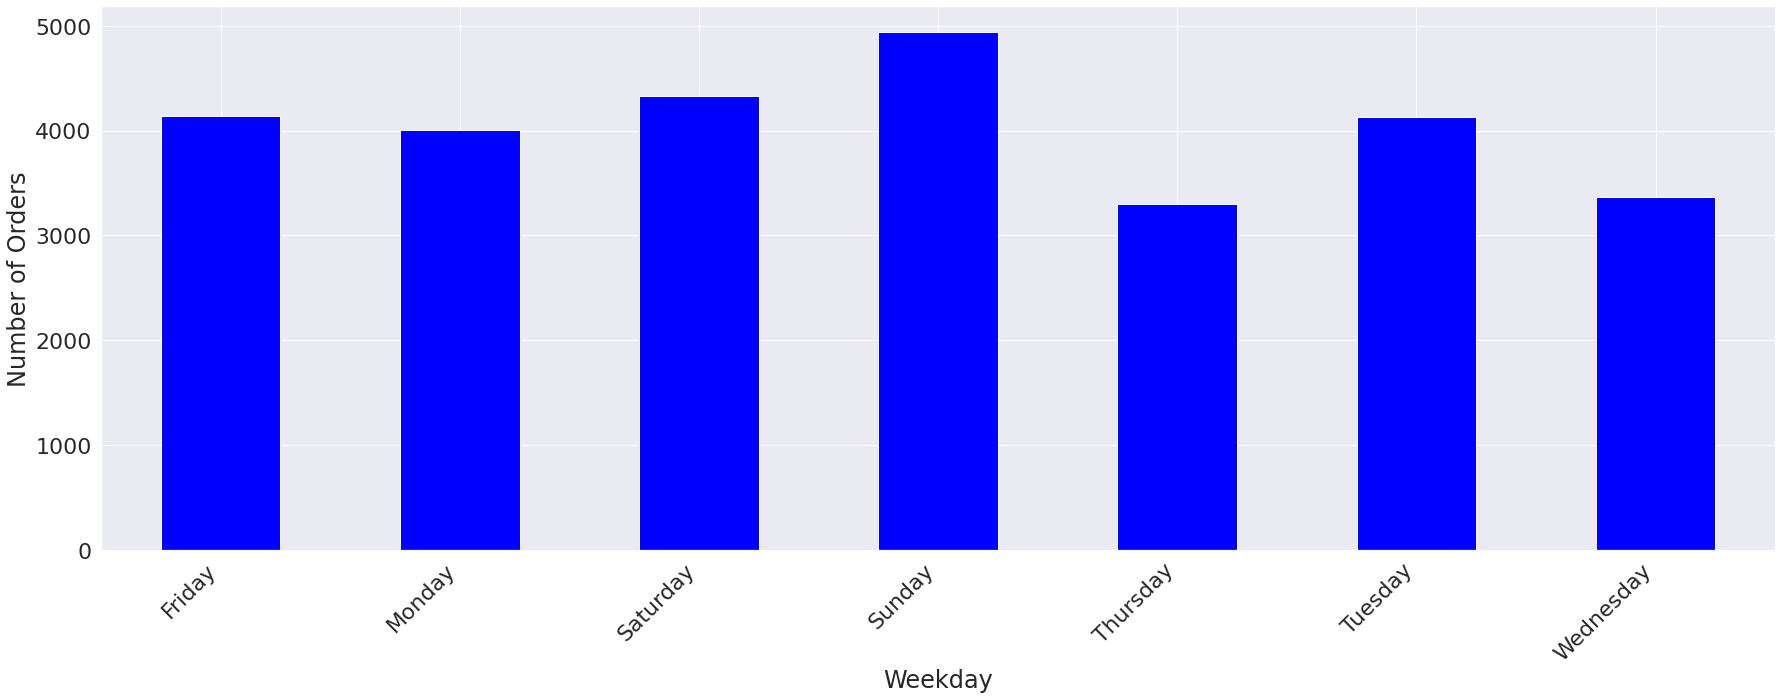

In [289]:
plt.figure(figsize=(30,10))
sns.set(font_scale=2)

df.groupby('order_ack_weekday').count()['order_acknowledged_at'].plot(kind='bar', color='blue')

plt.xlabel('Weekday')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')

Observation: Sundays have the highest number of orders

## Number of Orders by Hour

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

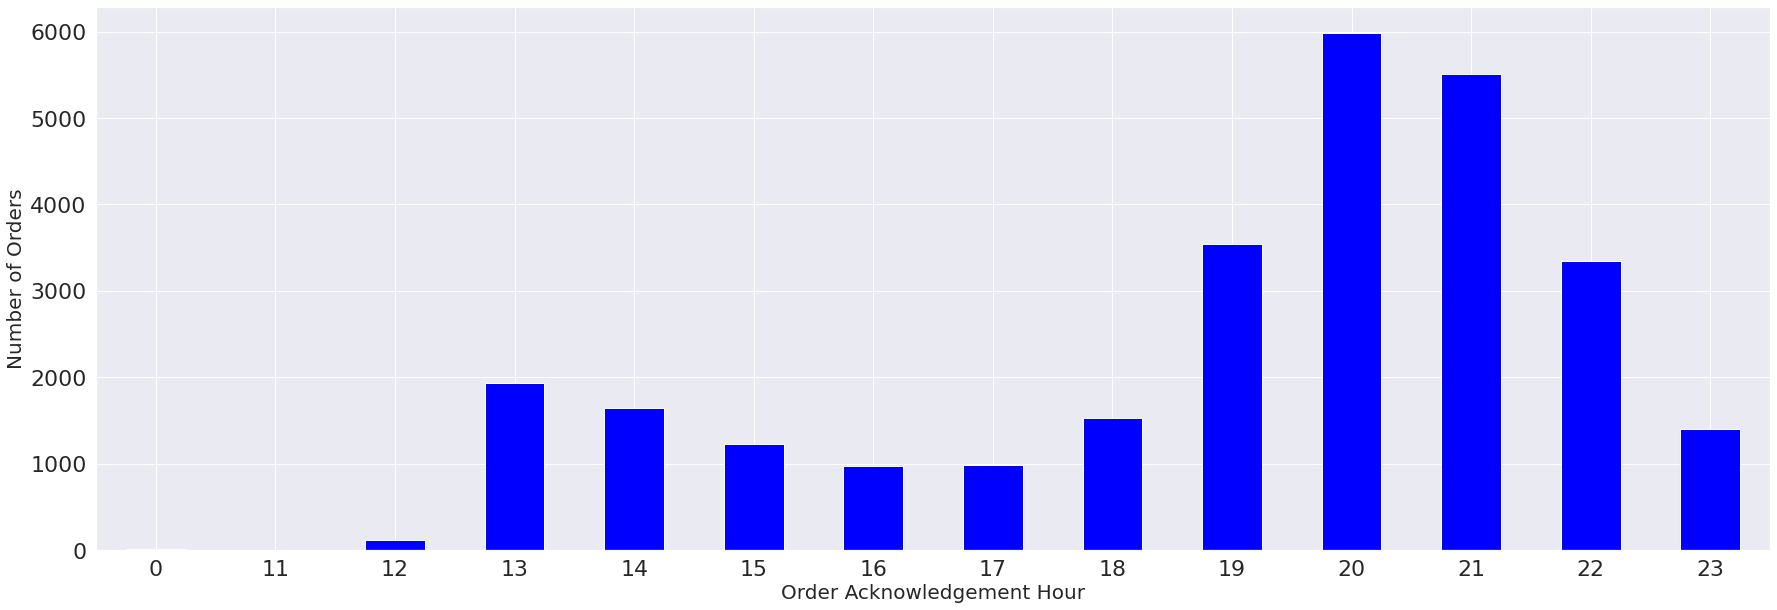

In [304]:
plt.figure(figsize=(30,10))
sns.set(font_scale=2)

df.groupby('order_ack_hour').count()['order_acknowledged_at'].plot(kind='bar', color='blue')

plt.xlabel('Order Acknowledgement Hour', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)
plt.xticks(rotation=0)

Observation: most of orders are placed between 7:00 pm to 10:00 pm

## Number of Orders by Country

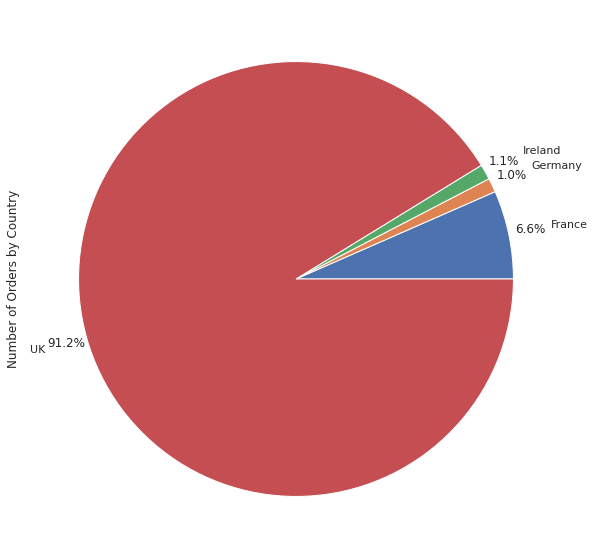

In [299]:
order_countries = pd.DataFrame(df.groupby('country').count()['order_acknowledged_at'])
total_orders = order_countries['order_acknowledged_at'].sum()
order_countries['percent'] = (order_countries['order_acknowledged_at'] / total_orders) * 100

plt.figure(figsize=(30,10))
sns.set(font_scale=1)

order_countries['percent'].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.2, label='Number of Orders by Country')

Observation : most of orders are in UK

## Number of Orders by Cuisine

Text(0, 0.5, 'Number of Orders')

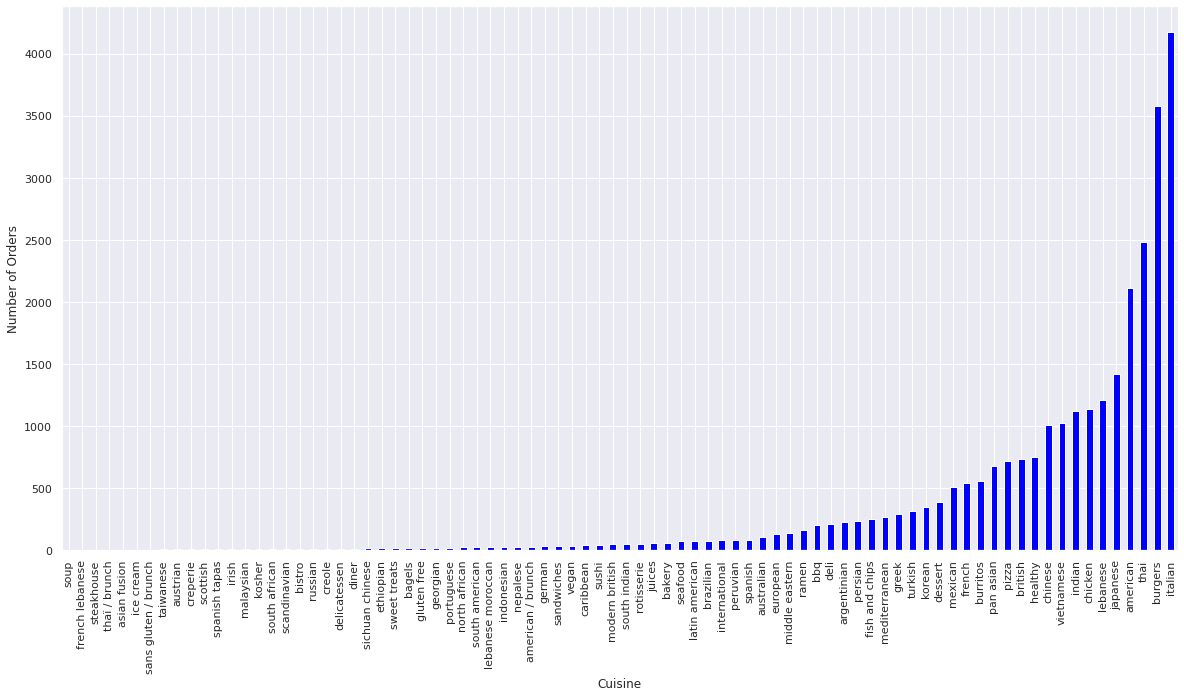

In [300]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)

df.groupby('type_of_food').count()['order_acknowledged_at'].sort_values().plot(kind='bar', color='blue')

plt.xlabel('Cuisine')
plt.ylabel('Number of Orders')

Observation : Italian, Burgers, Thai, and American and japanese has been ordered the most

## Average Order Value by City

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

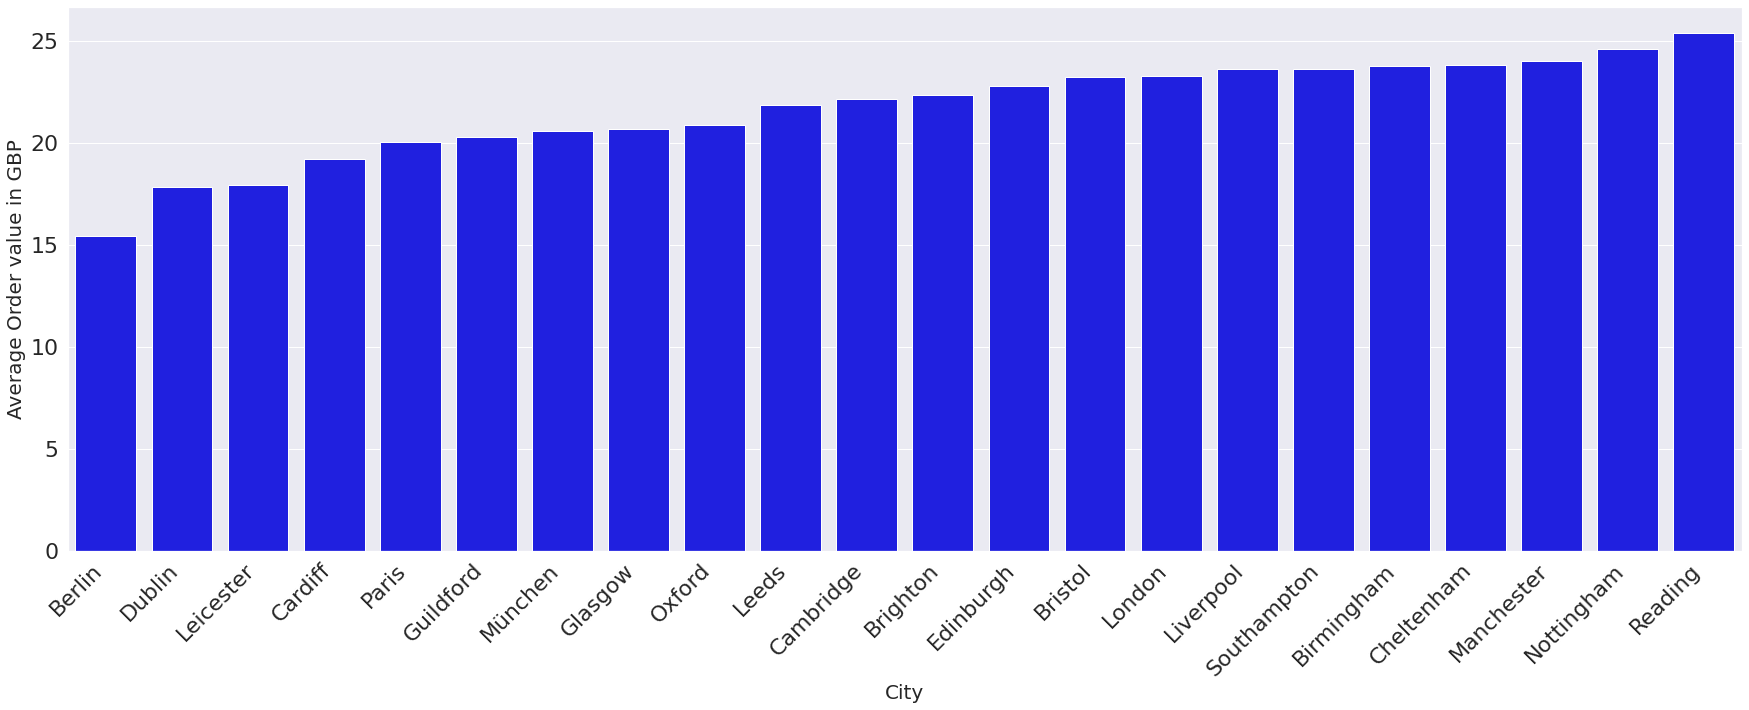

In [286]:
mean_order_value = pd.DataFrame(df.groupby('city').mean()['order_value_gbp']).sort_values(by='order_value_gbp')

plt.figure(figsize=(30,10))
sns.set(font_scale=2)

sns.barplot(x=mean_order_value.index, y=mean_order_value['order_value_gbp'], color='blue')

plt.xlabel('City', fontsize=20)
plt.ylabel('Average Order value in GBP', fontsize=20)
plt.xticks(rotation=45, ha='right')

## Distribution of Order Values

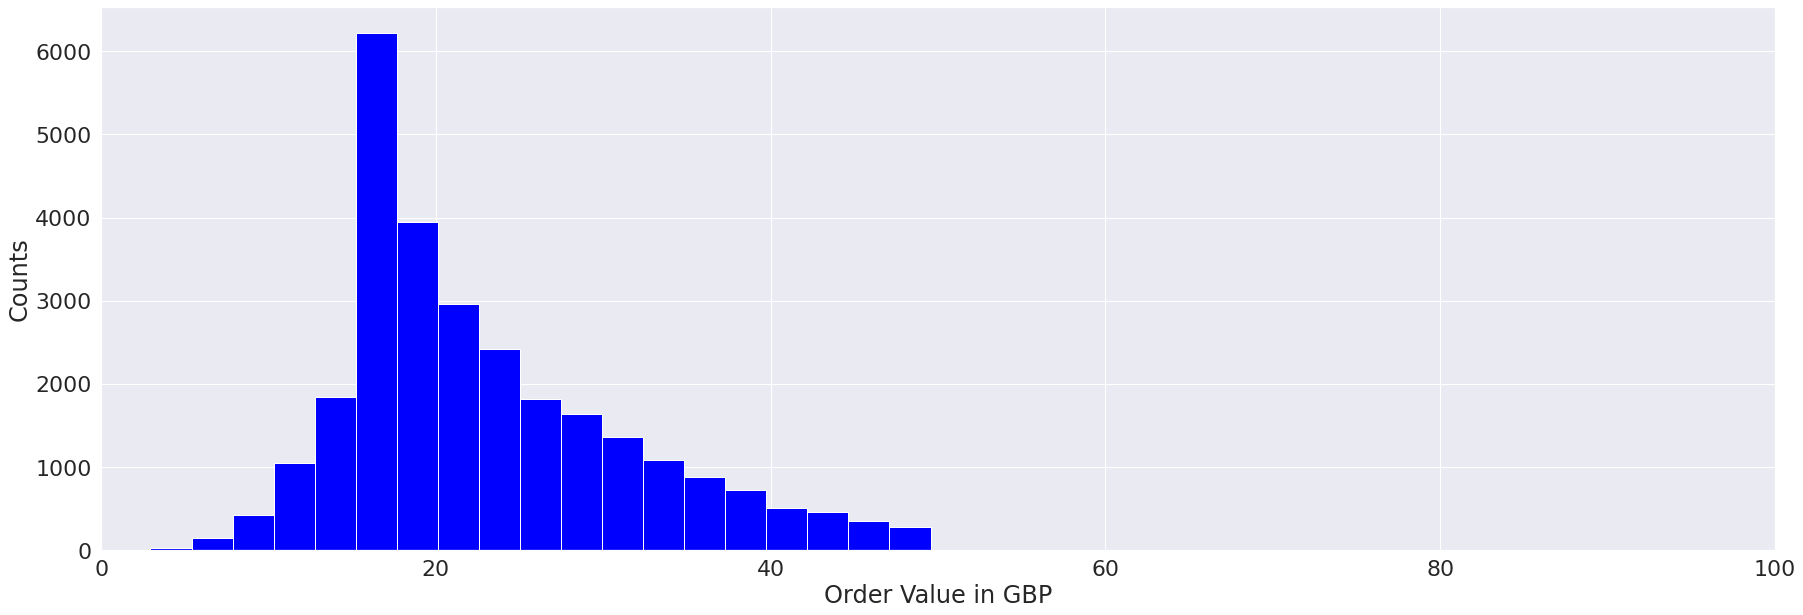

In [284]:
plt.figure(figsize=(30,10))
sns.set(font_scale=2)

plt.hist(df['order_value_gbp'], bins=20, color='blue')

plt.xlim(0, 100)
plt.ylabel('Counts')
plt.xlabel('Order Value in GBP')

Observation : majority of the orders are in the 10-40 GBP range

## Average Preparation Time by Country

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

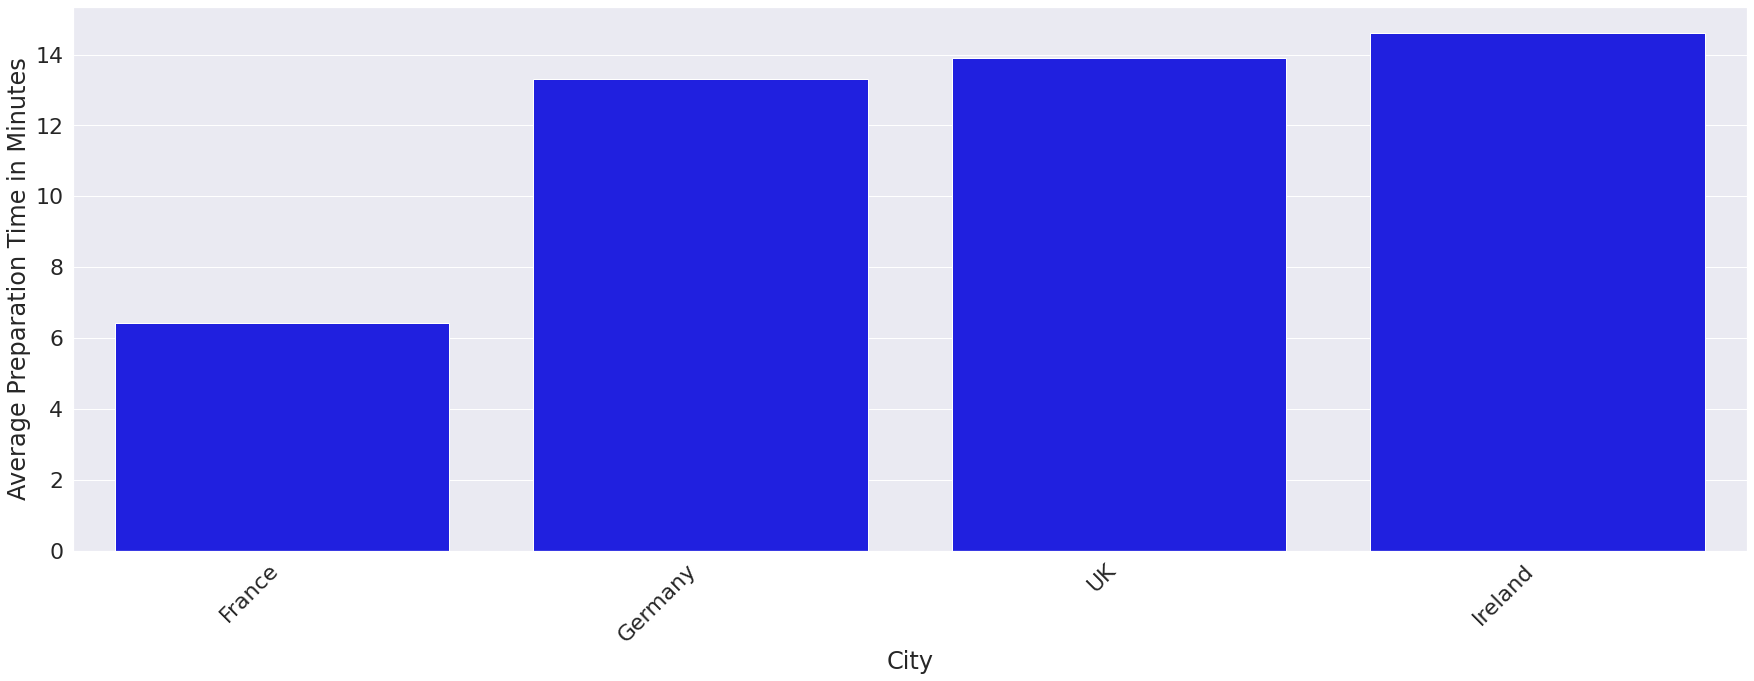

In [287]:
average_prep_time = pd.DataFrame(df.groupby('country').mean()['prep_time_seconds']).sort_values(by='prep_time_seconds')
average_prep_time['prep_time_min'] = average_prep_time['prep_time_seconds'] / 60

plt.figure(figsize=(30,10))
sns.set(font_scale=2)
sns.barplot(x=average_prep_time.index, y=average_prep_time['prep_time_min'], color='blue')

plt.xlabel('City')
plt.ylabel('Average Preparation Time in Minutes')
plt.xticks(rotation=45, ha='right')

## Average Preparation Time by Cuisine

Text(0, 0.5, 'Average Preparation Time in Minutes')

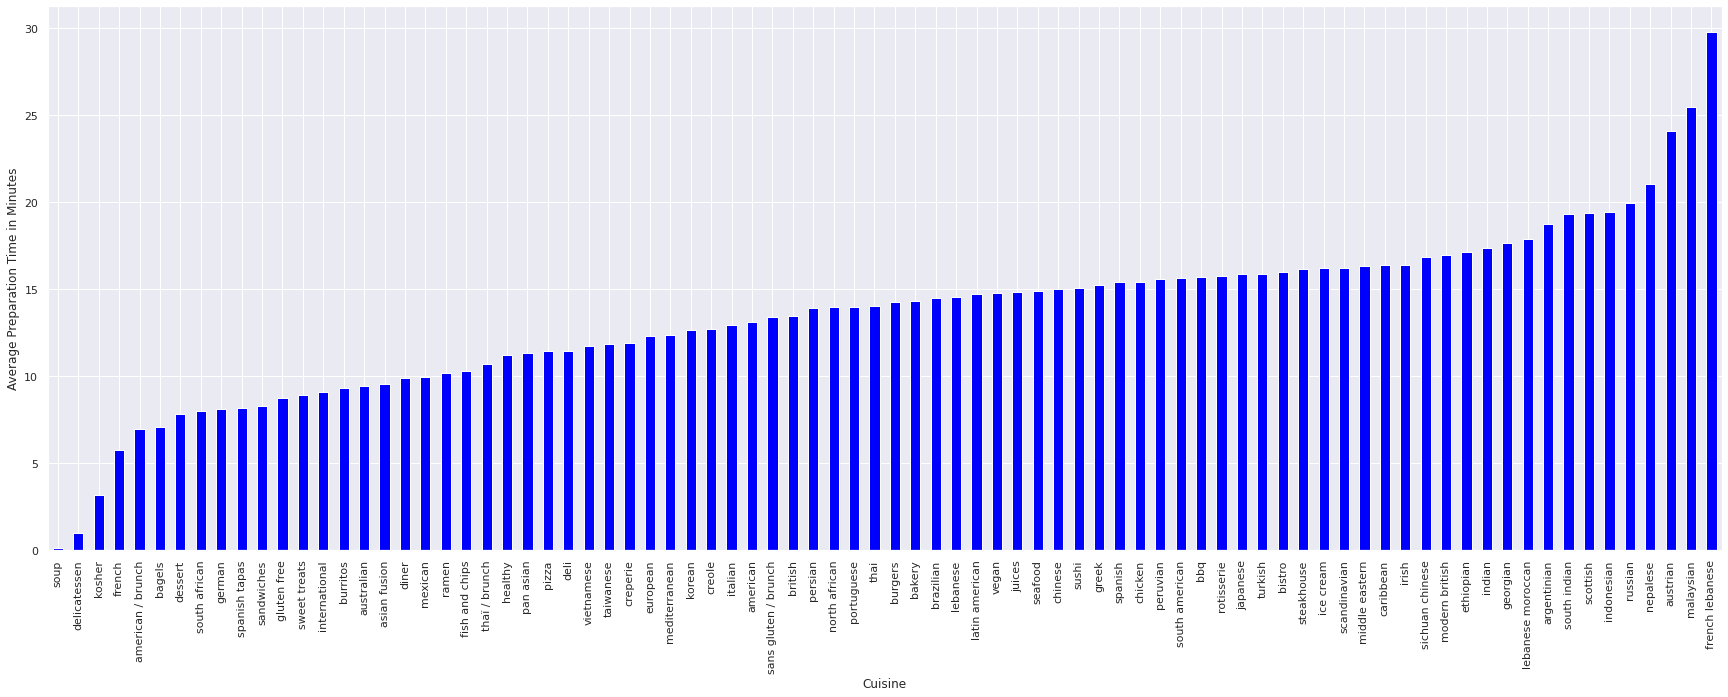

In [288]:
plt.figure(figsize=(30,10))
sns.set(font_scale=1)

average_prep_time = pd.DataFrame(df.groupby('type_of_food').mean()['prep_time_seconds']).sort_values(by='prep_time_seconds')
average_prep_time['prep_time_min'] = average_prep_time['prep_time_seconds'] / 60
average_prep_time['prep_time_min'].plot(kind='bar', color='blue')

plt.xlabel('Cuisine')
plt.ylabel('Average Preparation Time in Minutes')

# Modelling

## Feature Engineering

## Splitting the Dataset

## Evaluation

# Use-cases

# Further Work